In [1]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 120         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 140

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6
compute_val_at = 150

In [2]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\lai\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(df['high'], color='red', label='high')
    ax1.legend(loc='best')
 
    ax2.plot(df['low'], color='red', label='low')
    ax2.legend(loc='best')
    plt.show()

             high           low     close    change      50ma     100ma  \
199  4.445337e-14  6.182380e-03  0.357085 -0.000150  0.351429  0.351070   
200  2.002002e-03  1.545595e-02  0.356606 -0.000060  0.351433  0.351063   
201  1.301301e-02  7.727975e-03  0.356893  0.000035  0.351445  0.351060   
202  4.445337e-14  1.545595e-03  0.357133  0.000015  0.351502  0.351082   
203  6.006006e-03  6.863821e-14  0.358138  0.000095  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


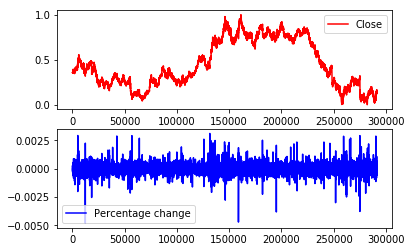

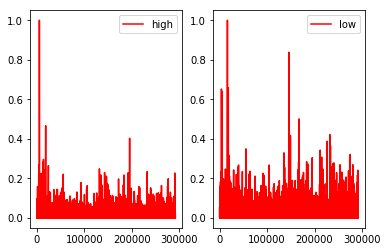

In [6]:
plot_stock(df)

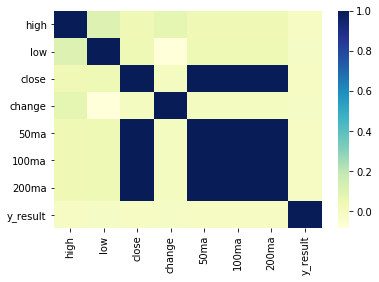

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [8]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 7
Amount of training data = 261918.9
Amount of testing data = 29102.100000000002
(174613, 120, 7) (174613,) (70626, 120, 7) (70626,)
7


In [10]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [11]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [12]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [13]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
interation_compute_val = 1
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    saver.restore(sess, "checkpoints/har-lstm.ckpt")
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == compute_val_at):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 0/140 Iteration: 5 Train loss: 0.964708 Train acc: 0.516113
Epoch: 0/140 Iteration: 10 Train loss: 0.971878 Train acc: 0.484863
Epoch: 0/140 Iteration: 15 Train loss: 1.035203 Train acc: 0.481445
Epoch: 0/140 Iteration: 20 Train loss: 0.998256 Train acc: 0.501465
Epoch: 0/140 Iteration: 25 Train loss: 1.105992 Train acc: 0.381836
Epoch: 0/140 Iteration: 30 Train loss: 0.979583 Train acc: 0.515625
Epoch: 0/140 Iteration: 35 Train loss: 0.904767 Train acc: 0.591309
Epoch: 0/140 Iteration: 40 Train loss: 0.863788 Train acc: 0.644531
Epoch: 0/140 Iteration: 45 Train loss: 1.030351 Train acc: 0.457031
Epoch: 0/140 Iteration: 50 Train loss: 0.846309 Train acc: 0.612305
Epoch: 0/140 Iteration: 55 Train loss: 0.942745 Train acc: 0.574219
Epoch: 0/140 Iteration: 60 Train loss: 1.147146 Train acc: 0.332031
Epoch: 0/140 Iteration: 65 Train loss: 0.985348 Train acc: 0.376953
Epoch: 0/140 Iteration: 70 Train loss: 0.987117 T

Epoch: 7/140 Iteration: 600 Train loss: 0.964768 Train acc: 0.522461
Epoch: 7/140 Iteration: 605 Train loss: 0.973223 Train acc: 0.490234
Epoch: 7/140 Iteration: 610 Train loss: 1.033633 Train acc: 0.472168
Epoch: 7/140 Iteration: 615 Train loss: 1.015894 Train acc: 0.495605
Epoch: 7/140 Iteration: 620 Train loss: 1.119873 Train acc: 0.367188
Epoch: 7/140 Iteration: 625 Train loss: 0.971027 Train acc: 0.526855
Epoch: 7/140 Iteration: 630 Train loss: 0.889301 Train acc: 0.599121
Epoch: 7/140 Iteration: 635 Train loss: 0.874935 Train acc: 0.649414
Epoch: 7/140 Iteration: 640 Train loss: 1.022703 Train acc: 0.455566
Epoch: 7/140 Iteration: 645 Train loss: 0.851677 Train acc: 0.601562
Epoch: 7/140 Iteration: 650 Train loss: 0.931145 Train acc: 0.588379
Epoch: 7/140 Iteration: 655 Train loss: 1.130613 Train acc: 0.362305
Epoch: 7/140 Iteration: 660 Train loss: 0.985632 Train acc: 0.366699
Epoch: 7/140 Iteration: 665 Train loss: 0.971425 Train acc: 0.448242
Epoch: 7/140 Iteration: 670 Train 

Epoch: 13/140 Iteration: 1190 Train loss: 1.063239 Train acc: 0.437500
Epoch: 14/140 Iteration: 1195 Train loss: 0.973622 Train acc: 0.500000
Epoch: 14/140 Iteration: 1200 Train loss: 0.969823 Train acc: 0.483398
Epoch: 14/140 Iteration: 1205 Train loss: 1.024764 Train acc: 0.487793
Epoch: 14/140 Iteration: 1210 Train loss: 0.996031 Train acc: 0.501953
Epoch: 14/140 Iteration: 1215 Train loss: 1.101250 Train acc: 0.391113
Epoch: 14/140 Iteration: 1220 Train loss: 0.986007 Train acc: 0.513672
Epoch: 14/140 Iteration: 1225 Train loss: 0.908034 Train acc: 0.596680
Epoch: 14/140 Iteration: 1230 Train loss: 0.872420 Train acc: 0.660156
Epoch: 14/140 Iteration: 1235 Train loss: 1.009660 Train acc: 0.490234
Epoch: 14/140 Iteration: 1240 Train loss: 0.856018 Train acc: 0.598633
Epoch: 14/140 Iteration: 1245 Train loss: 0.934064 Train acc: 0.575195
Epoch: 14/140 Iteration: 1250 Train loss: 1.082708 Train acc: 0.384277
Epoch: 14/140 Iteration: 1255 Train loss: 0.988182 Train acc: 0.376465
Epoch:

Epoch: 20/140 Iteration: 1770 Train loss: 0.964190 Train acc: 0.476562
Epoch: 20/140 Iteration: 1775 Train loss: 0.943242 Train acc: 0.459961
Epoch: 20/140 Iteration: 1780 Train loss: 1.036403 Train acc: 0.453125
Epoch: 20/140 Iteration: 1785 Train loss: 1.046227 Train acc: 0.452148
Epoch: 21/140 Iteration: 1790 Train loss: 0.952556 Train acc: 0.543945
Epoch: 21/140 Iteration: 1795 Train loss: 0.977359 Train acc: 0.505859
Epoch: 21/140 Iteration: 1800 Train loss: 1.000875 Train acc: 0.528320
Epoch: 21/140 Iteration: 1805 Train loss: 0.991544 Train acc: 0.523438
Epoch: 21/140 Iteration: 1810 Train loss: 1.106558 Train acc: 0.381348
Epoch: 21/140 Iteration: 1815 Train loss: 0.966952 Train acc: 0.534180
Epoch: 21/140 Iteration: 1820 Train loss: 0.861877 Train acc: 0.616211
Epoch: 21/140 Iteration: 1825 Train loss: 0.845768 Train acc: 0.670410
Epoch: 21/140 Iteration: 1830 Train loss: 1.009121 Train acc: 0.486328
Epoch: 21/140 Iteration: 1835 Train loss: 0.831568 Train acc: 0.628418
Epoch:

Epoch: 27/140 Iteration: 2350 Train loss: 0.922317 Train acc: 0.580078
Epoch: 27/140 Iteration: 2355 Train loss: 1.066919 Train acc: 0.467285
Epoch: 27/140 Iteration: 2360 Train loss: 0.969286 Train acc: 0.410156
Epoch: 27/140 Iteration: 2365 Train loss: 0.946959 Train acc: 0.495117
Epoch: 27/140 Iteration: 2370 Train loss: 0.933833 Train acc: 0.446777
Epoch: 27/140 Iteration: 2375 Train loss: 1.058577 Train acc: 0.443359
Epoch: 27/140 Iteration: 2380 Train loss: 0.988222 Train acc: 0.458008
Epoch: 28/140 Iteration: 2385 Train loss: 0.950314 Train acc: 0.529297
Epoch: 28/140 Iteration: 2390 Train loss: 0.969897 Train acc: 0.491699
Epoch: 28/140 Iteration: 2395 Train loss: 1.003203 Train acc: 0.504395
Epoch: 28/140 Iteration: 2400 Train loss: 0.975425 Train acc: 0.509766
Epoch: 28/140 Iteration: 2405 Train loss: 1.097044 Train acc: 0.396973
Epoch: 28/140 Iteration: 2410 Train loss: 0.946770 Train acc: 0.562012
Epoch: 28/140 Iteration: 2415 Train loss: 0.875764 Train acc: 0.610840
Epoch:

Epoch: 34/140 Iteration: 2930 Train loss: 0.827949 Train acc: 0.653809
Epoch: 34/140 Iteration: 2935 Train loss: 0.986013 Train acc: 0.470703
Epoch: 34/140 Iteration: 2940 Train loss: 0.850198 Train acc: 0.609863
Epoch: 34/140 Iteration: 2945 Train loss: 0.927040 Train acc: 0.593750
Epoch: 34/140 Iteration: 2950 Train loss: 1.043231 Train acc: 0.485352
Epoch: 34/140 Iteration: 2955 Train loss: 0.964124 Train acc: 0.404785
Epoch: 34/140 Iteration: 2960 Train loss: 0.937960 Train acc: 0.497070
Epoch: 34/140 Iteration: 2965 Train loss: 0.921747 Train acc: 0.468750
Epoch: 34/140 Iteration: 2970 Train loss: 1.034847 Train acc: 0.452148
Epoch: 34/140 Iteration: 2975 Train loss: 0.990725 Train acc: 0.493652
Epoch: 35/140 Iteration: 2980 Train loss: 0.938064 Train acc: 0.537598
Epoch: 35/140 Iteration: 2985 Train loss: 0.969242 Train acc: 0.499023
Epoch: 35/140 Iteration: 2990 Train loss: 0.985815 Train acc: 0.517090
Epoch: 35/140 Iteration: 2995 Train loss: 0.992154 Train acc: 0.511719
Epoch:

Epoch: 41/140 Iteration: 3510 Train loss: 1.053163 Train acc: 0.403320
Epoch: 41/140 Iteration: 3515 Train loss: 0.909134 Train acc: 0.583984
Epoch: 41/140 Iteration: 3520 Train loss: 0.861326 Train acc: 0.619629
Epoch: 41/140 Iteration: 3525 Train loss: 0.797077 Train acc: 0.677734
Epoch: 41/140 Iteration: 3530 Train loss: 0.988122 Train acc: 0.484863
Epoch: 41/140 Iteration: 3535 Train loss: 0.818586 Train acc: 0.632812
Epoch: 41/140 Iteration: 3540 Train loss: 0.912408 Train acc: 0.606934
Epoch: 41/140 Iteration: 3545 Train loss: 1.063993 Train acc: 0.436035
Epoch: 41/140 Iteration: 3550 Train loss: 0.999493 Train acc: 0.385742
Epoch: 41/140 Iteration: 3555 Train loss: 0.967916 Train acc: 0.459473
Epoch: 41/140 Iteration: 3560 Train loss: 0.946826 Train acc: 0.471191
Epoch: 41/140 Iteration: 3565 Train loss: 1.005625 Train acc: 0.462402
Epoch: 41/140 Iteration: 3570 Train loss: 0.990704 Train acc: 0.453613
Epoch: 42/140 Iteration: 3575 Train loss: 0.948972 Train acc: 0.553711
Epoch:

Epoch: 48/140 Iteration: 4090 Train loss: 0.953896 Train acc: 0.516113
Epoch: 48/140 Iteration: 4095 Train loss: 0.954910 Train acc: 0.535156
Epoch: 48/140 Iteration: 4100 Train loss: 0.921737 Train acc: 0.567871
Epoch: 48/140 Iteration: 4105 Train loss: 1.070127 Train acc: 0.413574
Epoch: 48/140 Iteration: 4110 Train loss: 0.846353 Train acc: 0.638184
Epoch: 48/140 Iteration: 4115 Train loss: 0.858406 Train acc: 0.610352
Epoch: 48/140 Iteration: 4120 Train loss: 0.796465 Train acc: 0.670898
Epoch: 48/140 Iteration: 4125 Train loss: 0.948449 Train acc: 0.519043
Epoch: 48/140 Iteration: 4130 Train loss: 0.858604 Train acc: 0.607910
Epoch: 48/140 Iteration: 4135 Train loss: 0.895866 Train acc: 0.631348
Epoch: 48/140 Iteration: 4140 Train loss: 1.048632 Train acc: 0.478027
Epoch: 48/140 Iteration: 4145 Train loss: 0.976145 Train acc: 0.384766
Epoch: 48/140 Iteration: 4150 Train loss: 0.969722 Train acc: 0.493164
Epoch: 48/140 Iteration: 4155 Train loss: 0.925067 Train acc: 0.455078
Epoch:

Epoch: 54/140 Iteration: 4670 Train loss: 1.000009 Train acc: 0.452637
Epoch: 54/140 Iteration: 4675 Train loss: 0.965134 Train acc: 0.469238
Epoch: 55/140 Iteration: 4680 Train loss: 0.929977 Train acc: 0.567871
Epoch: 55/140 Iteration: 4685 Train loss: 0.972121 Train acc: 0.510742
Epoch: 55/140 Iteration: 4690 Train loss: 0.932883 Train acc: 0.531738
Epoch: 55/140 Iteration: 4695 Train loss: 0.919401 Train acc: 0.578613
Epoch: 55/140 Iteration: 4700 Train loss: 1.041097 Train acc: 0.419434
Epoch: 55/140 Iteration: 4705 Train loss: 0.841783 Train acc: 0.628418
Epoch: 55/140 Iteration: 4710 Train loss: 0.781492 Train acc: 0.703613
Epoch: 55/140 Iteration: 4715 Train loss: 0.773801 Train acc: 0.684082
Epoch: 55/140 Iteration: 4720 Train loss: 0.949887 Train acc: 0.504395
Epoch: 55/140 Iteration: 4725 Train loss: 0.780876 Train acc: 0.682129
Epoch: 55/140 Iteration: 4730 Train loss: 0.876559 Train acc: 0.652344
Epoch: 55/140 Iteration: 4735 Train loss: 1.003451 Train acc: 0.510742
Epoch:

Epoch: 61/140 Iteration: 5250 Train loss: 0.960921 Train acc: 0.401367
Epoch: 61/140 Iteration: 5255 Train loss: 0.927903 Train acc: 0.464355
Epoch: 61/140 Iteration: 5260 Train loss: 0.939445 Train acc: 0.463867
Epoch: 61/140 Iteration: 5265 Train loss: 1.043174 Train acc: 0.451172
Epoch: 61/140 Iteration: 5270 Train loss: 1.028347 Train acc: 0.402832
Epoch: 62/140 Iteration: 5275 Train loss: 0.953412 Train acc: 0.563477
Epoch: 62/140 Iteration: 5280 Train loss: 0.959454 Train acc: 0.508301
Epoch: 62/140 Iteration: 5285 Train loss: 0.906819 Train acc: 0.548828
Epoch: 62/140 Iteration: 5290 Train loss: 0.904126 Train acc: 0.578125
Epoch: 62/140 Iteration: 5295 Train loss: 0.998993 Train acc: 0.467773
Epoch: 62/140 Iteration: 5300 Train loss: 0.817994 Train acc: 0.616211
Epoch: 62/140 Iteration: 5305 Train loss: 0.724550 Train acc: 0.728027
Epoch: 62/140 Iteration: 5310 Train loss: 0.792899 Train acc: 0.666992
Epoch: 62/140 Iteration: 5315 Train loss: 0.967251 Train acc: 0.500977
Epoch:

Epoch: 68/140 Iteration: 5830 Train loss: 0.779027 Train acc: 0.685059
Epoch: 68/140 Iteration: 5835 Train loss: 0.880495 Train acc: 0.621582
Epoch: 68/140 Iteration: 5840 Train loss: 1.103148 Train acc: 0.417969
Epoch: 68/140 Iteration: 5845 Train loss: 0.963299 Train acc: 0.427246
Epoch: 68/140 Iteration: 5850 Train loss: 0.929826 Train acc: 0.470215
Epoch: 68/140 Iteration: 5855 Train loss: 0.910926 Train acc: 0.508789
Epoch: 68/140 Iteration: 5860 Train loss: 1.029538 Train acc: 0.479004
Epoch: 68/140 Iteration: 5865 Train loss: 1.039468 Train acc: 0.434570
Epoch: 69/140 Iteration: 5870 Train loss: 0.953766 Train acc: 0.565918
Epoch: 69/140 Iteration: 5875 Train loss: 0.933209 Train acc: 0.505859
Epoch: 69/140 Iteration: 5880 Train loss: 0.862085 Train acc: 0.580566
Epoch: 69/140 Iteration: 5885 Train loss: 0.903928 Train acc: 0.570312
Epoch: 69/140 Iteration: 5890 Train loss: 1.006389 Train acc: 0.481934
Epoch: 69/140 Iteration: 5895 Train loss: 0.766420 Train acc: 0.647461
Epoch:

Epoch: 75/140 Iteration: 6410 Train loss: 0.708359 Train acc: 0.709473
Epoch: 75/140 Iteration: 6415 Train loss: 0.801856 Train acc: 0.656250
Epoch: 75/140 Iteration: 6420 Train loss: 0.956553 Train acc: 0.507812
Epoch: 75/140 Iteration: 6425 Train loss: 0.768049 Train acc: 0.690918
Epoch: 75/140 Iteration: 6430 Train loss: 0.864213 Train acc: 0.642578
Epoch: 75/140 Iteration: 6435 Train loss: 0.986715 Train acc: 0.539551
Epoch: 75/140 Iteration: 6440 Train loss: 0.918445 Train acc: 0.497559
Epoch: 75/140 Iteration: 6445 Train loss: 0.895088 Train acc: 0.530273
Epoch: 75/140 Iteration: 6450 Train loss: 0.931824 Train acc: 0.468750
Epoch: 75/140 Iteration: 6455 Train loss: 1.034395 Train acc: 0.454590
Epoch: 75/140 Iteration: 6460 Train loss: 1.008495 Train acc: 0.428711
Epoch: 76/140 Iteration: 6465 Train loss: 0.894205 Train acc: 0.617676
Epoch: 76/140 Iteration: 6470 Train loss: 0.926015 Train acc: 0.527832
Epoch: 76/140 Iteration: 6475 Train loss: 0.837867 Train acc: 0.586914
Epoch:

Epoch: 82/140 Iteration: 6990 Train loss: 0.833413 Train acc: 0.641602
Epoch: 82/140 Iteration: 6995 Train loss: 0.948155 Train acc: 0.522461
Epoch: 82/140 Iteration: 7000 Train loss: 0.729102 Train acc: 0.652832
Epoch: 82/140 Iteration: 7005 Train loss: 0.688670 Train acc: 0.751465
Epoch: 82/140 Iteration: 7010 Train loss: 0.753807 Train acc: 0.702637
Epoch: 82/140 Iteration: 7015 Train loss: 0.910696 Train acc: 0.528320
Epoch: 82/140 Iteration: 7020 Train loss: 0.703867 Train acc: 0.739258
Epoch: 82/140 Iteration: 7025 Train loss: 0.865134 Train acc: 0.633789
Epoch: 82/140 Iteration: 7030 Train loss: 0.953185 Train acc: 0.577637
Epoch: 82/140 Iteration: 7035 Train loss: 0.912999 Train acc: 0.492188
Epoch: 82/140 Iteration: 7040 Train loss: 0.917230 Train acc: 0.496094
Epoch: 82/140 Iteration: 7045 Train loss: 0.880638 Train acc: 0.541992
Epoch: 82/140 Iteration: 7050 Train loss: 0.985479 Train acc: 0.504395
Epoch: 82/140 Iteration: 7055 Train loss: 0.960515 Train acc: 0.468262
Epoch:

Epoch: 89/140 Iteration: 7570 Train loss: 0.878282 Train acc: 0.602539
Epoch: 89/140 Iteration: 7575 Train loss: 0.875212 Train acc: 0.591797
Epoch: 89/140 Iteration: 7580 Train loss: 0.809613 Train acc: 0.622559
Epoch: 89/140 Iteration: 7585 Train loss: 0.823801 Train acc: 0.631348
Epoch: 89/140 Iteration: 7590 Train loss: 0.926551 Train acc: 0.539551
Epoch: 89/140 Iteration: 7595 Train loss: 0.732359 Train acc: 0.665039
Epoch: 89/140 Iteration: 7600 Train loss: 0.640098 Train acc: 0.761719
Epoch: 89/140 Iteration: 7605 Train loss: 0.706093 Train acc: 0.717773
Epoch: 89/140 Iteration: 7610 Train loss: 0.911286 Train acc: 0.520508
Epoch: 89/140 Iteration: 7615 Train loss: 0.678766 Train acc: 0.753906
Epoch: 89/140 Iteration: 7620 Train loss: 0.819801 Train acc: 0.666504
Epoch: 89/140 Iteration: 7625 Train loss: 0.950840 Train acc: 0.567383
Epoch: 89/140 Iteration: 7630 Train loss: 0.927982 Train acc: 0.452637
Epoch: 89/140 Iteration: 7635 Train loss: 0.928588 Train acc: 0.543457
Epoch:

Epoch: 95/140 Iteration: 8150 Train loss: 0.908825 Train acc: 0.503906
Epoch: 95/140 Iteration: 8155 Train loss: 0.934221 Train acc: 0.545898
Epoch: 95/140 Iteration: 8160 Train loss: 0.948716 Train acc: 0.461426
Epoch: 96/140 Iteration: 8165 Train loss: 0.833663 Train acc: 0.633789
Epoch: 96/140 Iteration: 8170 Train loss: 0.807853 Train acc: 0.623535
Epoch: 96/140 Iteration: 8175 Train loss: 0.741645 Train acc: 0.664062
Epoch: 96/140 Iteration: 8180 Train loss: 0.775347 Train acc: 0.659180
Epoch: 96/140 Iteration: 8185 Train loss: 0.914177 Train acc: 0.565430
Epoch: 96/140 Iteration: 8190 Train loss: 0.706852 Train acc: 0.674805
Epoch: 96/140 Iteration: 8195 Train loss: 0.555681 Train acc: 0.787598
Epoch: 96/140 Iteration: 8200 Train loss: 0.663569 Train acc: 0.741211
Epoch: 96/140 Iteration: 8205 Train loss: 0.787464 Train acc: 0.625000
Epoch: 96/140 Iteration: 8210 Train loss: 0.629923 Train acc: 0.781250
Epoch: 96/140 Iteration: 8215 Train loss: 0.822724 Train acc: 0.648438
Epoch:

Epoch: 102/140 Iteration: 8725 Train loss: 0.772882 Train acc: 0.688477
Epoch: 102/140 Iteration: 8730 Train loss: 0.912071 Train acc: 0.607910
Epoch: 102/140 Iteration: 8735 Train loss: 0.836686 Train acc: 0.587402
Epoch: 102/140 Iteration: 8740 Train loss: 0.841220 Train acc: 0.588867
Epoch: 102/140 Iteration: 8745 Train loss: 0.901498 Train acc: 0.512695
Epoch: 102/140 Iteration: 8750 Train loss: 0.923373 Train acc: 0.526855
Epoch: 102/140 Iteration: 8755 Train loss: 0.900679 Train acc: 0.501465
Epoch: 103/140 Iteration: 8760 Train loss: 0.831530 Train acc: 0.646484
Epoch: 103/140 Iteration: 8765 Train loss: 0.783062 Train acc: 0.666992
Epoch: 103/140 Iteration: 8770 Train loss: 0.694405 Train acc: 0.696777
Epoch: 103/140 Iteration: 8775 Train loss: 0.756951 Train acc: 0.665527
Epoch: 103/140 Iteration: 8780 Train loss: 0.798059 Train acc: 0.641113
Epoch: 103/140 Iteration: 8785 Train loss: 0.680059 Train acc: 0.714355
Epoch: 103/140 Iteration: 8790 Train loss: 0.520338 Train acc: 0

Epoch: 109/140 Iteration: 9295 Train loss: 0.689035 Train acc: 0.710449
Epoch: 109/140 Iteration: 9300 Train loss: 0.683764 Train acc: 0.742676
Epoch: 109/140 Iteration: 9305 Train loss: 0.621218 Train acc: 0.740723
Epoch: 109/140 Iteration: 9310 Train loss: 0.805364 Train acc: 0.617188
Epoch: 109/140 Iteration: 9315 Train loss: 0.648582 Train acc: 0.788574
Epoch: 109/140 Iteration: 9320 Train loss: 0.746529 Train acc: 0.709961
Epoch: 109/140 Iteration: 9325 Train loss: 0.858454 Train acc: 0.612793
Epoch: 109/140 Iteration: 9330 Train loss: 0.851407 Train acc: 0.580078
Epoch: 109/140 Iteration: 9335 Train loss: 0.872870 Train acc: 0.539062
Epoch: 109/140 Iteration: 9340 Train loss: 0.855401 Train acc: 0.578613
Epoch: 109/140 Iteration: 9345 Train loss: 0.921281 Train acc: 0.588379
Epoch: 109/140 Iteration: 9350 Train loss: 0.950286 Train acc: 0.502930
Epoch: 110/140 Iteration: 9355 Train loss: 0.831263 Train acc: 0.627441
Epoch: 110/140 Iteration: 9360 Train loss: 0.789239 Train acc: 0

Epoch: 116/140 Iteration: 9865 Train loss: 0.759211 Train acc: 0.683594
Epoch: 116/140 Iteration: 9870 Train loss: 0.808845 Train acc: 0.630371
Epoch: 116/140 Iteration: 9875 Train loss: 0.806350 Train acc: 0.649902
Epoch: 116/140 Iteration: 9880 Train loss: 0.653198 Train acc: 0.725586
Epoch: 116/140 Iteration: 9885 Train loss: 0.756971 Train acc: 0.686035
Epoch: 116/140 Iteration: 9890 Train loss: 0.624729 Train acc: 0.733398
Epoch: 116/140 Iteration: 9895 Train loss: 0.478899 Train acc: 0.819336
Epoch: 116/140 Iteration: 9900 Train loss: 0.687907 Train acc: 0.713379
Epoch: 116/140 Iteration: 9905 Train loss: 0.710037 Train acc: 0.685059
Epoch: 116/140 Iteration: 9910 Train loss: 0.637654 Train acc: 0.760254
Epoch: 116/140 Iteration: 9915 Train loss: 0.759035 Train acc: 0.703613
Epoch: 116/140 Iteration: 9920 Train loss: 0.865240 Train acc: 0.621582
Epoch: 116/140 Iteration: 9925 Train loss: 0.807084 Train acc: 0.628418
Epoch: 116/140 Iteration: 9930 Train loss: 0.845932 Train acc: 0

Epoch: 122/140 Iteration: 10430 Train loss: 0.815235 Train acc: 0.629883
Epoch: 122/140 Iteration: 10435 Train loss: 0.807331 Train acc: 0.599609
Epoch: 122/140 Iteration: 10440 Train loss: 0.863613 Train acc: 0.562500
Epoch: 122/140 Iteration: 10445 Train loss: 0.820372 Train acc: 0.599121
Epoch: 122/140 Iteration: 10450 Train loss: 0.963866 Train acc: 0.561523
Epoch: 122/140 Iteration: 10455 Train loss: 0.885764 Train acc: 0.534668
Epoch: 123/140 Iteration: 10460 Train loss: 0.782653 Train acc: 0.673828
Epoch: 123/140 Iteration: 10465 Train loss: 0.796217 Train acc: 0.645020
Epoch: 123/140 Iteration: 10470 Train loss: 0.774534 Train acc: 0.641113
Epoch: 123/140 Iteration: 10475 Train loss: 0.646497 Train acc: 0.743164
Epoch: 123/140 Iteration: 10480 Train loss: 0.706922 Train acc: 0.688477
Epoch: 123/140 Iteration: 10485 Train loss: 0.606607 Train acc: 0.732422
Epoch: 123/140 Iteration: 10490 Train loss: 0.413821 Train acc: 0.853516
Epoch: 123/140 Iteration: 10495 Train loss: 0.57036

Epoch: 129/140 Iteration: 10995 Train loss: 0.607649 Train acc: 0.734375
Epoch: 129/140 Iteration: 11000 Train loss: 0.495882 Train acc: 0.813477
Epoch: 129/140 Iteration: 11005 Train loss: 0.592375 Train acc: 0.756348
Epoch: 129/140 Iteration: 11010 Train loss: 0.692278 Train acc: 0.705078
Epoch: 129/140 Iteration: 11015 Train loss: 0.561036 Train acc: 0.807129
Epoch: 129/140 Iteration: 11020 Train loss: 0.768434 Train acc: 0.706055
Epoch: 129/140 Iteration: 11025 Train loss: 0.853502 Train acc: 0.624023
Epoch: 129/140 Iteration: 11030 Train loss: 0.813565 Train acc: 0.613281
Epoch: 129/140 Iteration: 11035 Train loss: 0.809278 Train acc: 0.628906
Epoch: 129/140 Iteration: 11040 Train loss: 0.842870 Train acc: 0.568359
Epoch: 129/140 Iteration: 11045 Train loss: 0.863197 Train acc: 0.586914
Epoch: 129/140 Iteration: 11050 Train loss: 0.865237 Train acc: 0.562500
Epoch: 130/140 Iteration: 11055 Train loss: 0.741500 Train acc: 0.697266
Epoch: 130/140 Iteration: 11060 Train loss: 0.77379

Epoch: 135/140 Iteration: 11560 Train loss: 0.832793 Train acc: 0.582520
Epoch: 136/140 Iteration: 11565 Train loss: 0.769377 Train acc: 0.679199
Epoch: 136/140 Iteration: 11570 Train loss: 0.778454 Train acc: 0.663086
Epoch: 136/140 Iteration: 11575 Train loss: 0.741051 Train acc: 0.680176
Epoch: 136/140 Iteration: 11580 Train loss: 0.667129 Train acc: 0.724609
Epoch: 136/140 Iteration: 11585 Train loss: 0.710478 Train acc: 0.685059
Epoch: 136/140 Iteration: 11590 Train loss: 0.538449 Train acc: 0.778320
Epoch: 136/140 Iteration: 11595 Train loss: 0.438289 Train acc: 0.839355
Epoch: 136/140 Iteration: 11600 Train loss: 0.558535 Train acc: 0.769531
Epoch: 136/140 Iteration: 11605 Train loss: 0.681430 Train acc: 0.726074
Epoch: 136/140 Iteration: 11610 Train loss: 0.581345 Train acc: 0.799805
Epoch: 136/140 Iteration: 11615 Train loss: 0.719384 Train acc: 0.712891
Epoch: 136/140 Iteration: 11620 Train loss: 0.797517 Train acc: 0.651367
Epoch: 136/140 Iteration: 11625 Train loss: 0.82597

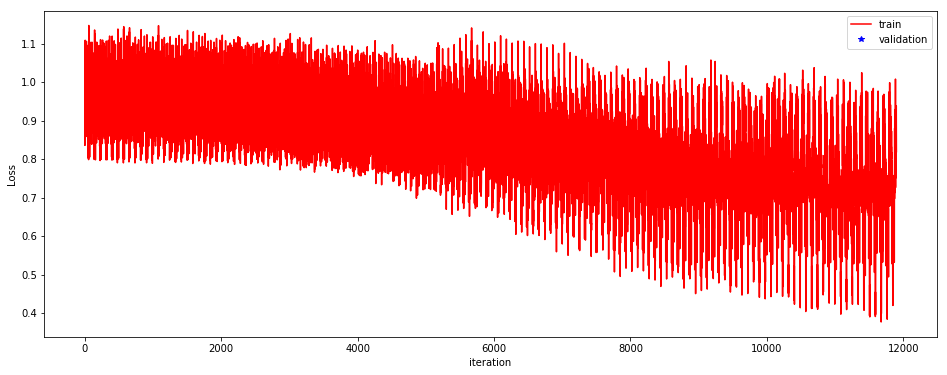

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (16,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % interation_compute_val == compute_val_at], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

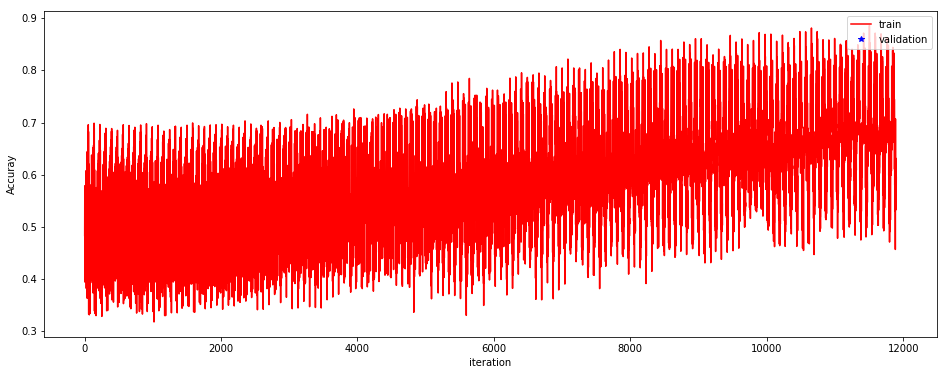

In [17]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (16,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % interation_compute_val == compute_val_at], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [41]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    sess.run(tf.local_variables_initializer())
    saver = tf.train.import_meta_graph('checkpoints\har-lstm.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)        
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size): 
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([ accuracy,final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70626, 3)
0.42041
0.374512
0.375488
0.549316
0.459961
0.35791
0.368164
0.481934
0.421387
0.44043
0.471191
0.473633
0.428223
0.541504
0.350098
0.420898
0.364258
0.304688
0.166016
0.218262
0.222168
0.22998
0.32373
0.282227
0.24707
0.29248
0.253418
0.171387
0.258789
0.408691
0.334473
0.337891
0.243652
0.291504
Test accuracy: 0.349581


In [19]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


[[ 0  1  2  0  4  5  6  7  8 10]
 [ 0 11  0 13  0 15  0 17 18  0]]


In [20]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

[[0 1 2 0 4 5 6 7 8 9]]


In [21]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

NameError: name 'ytest' is not defined

In [42]:
print(50%1)

0
